### Thresholding


In [1]:
from confocalQuant.segmentation import show_im, load_2D, threshold_im, update_image

channels = [0,1,2]
path = '../image_analysis2/D04_1.czi'
im, bounds = show_im(path, N_channels = channels)

im

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [2]:
bounds

{0: (1, 99), 1: (48.89, 99.84), 2: (1, 99)}

### Apply Thresholds & Do inference

In [18]:
import numpy as np
from aicsimageio import AICSImage
from confocalQuant.segmentation import load_3D, apply_thresh_all_Z, do_inference, get_anisotropy, sigmoid
import torch as ch
from tqdm import tqdm

In [7]:
# load image with channels from above
img = AICSImage(path)
out = load_3D(img, channels)

# load the model
model = ch.load('./models/cyto2')

# thresholding
mat = apply_thresh_all_Z(out, bounds)

100%|██████████| 20/20 [00:02<00:00,  6.97it/s]


In [8]:
anisotropy = get_anisotropy(img)
print(anisotropy)

2.1476913444983565


In [9]:
# do inference
masks, flows = do_inference(mat, do_3D=True, model=model, anisotropy=anisotropy)

In [22]:
np.save('./temp/masks_temp.npy', masks)
np.save('./temp/probs_temp.npy', sigmoid(flows[2]))
np.save('./temp/mat_temp.npy', mat)

### Toggle through segmentation

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from confocalQuant.segmentation import toggle_segmentation, extract_channels, toggle_segmentation, show_maxproj_with_outlines, hide_masks
from confocalQuant.quantification import get_im_stats


/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [2]:
# show without filtering
masks = np.load('./temp/masks_temp.npy')
mat = np.load('./temp/mat_temp.npy')
probs = np.load('./temp/probs_temp.npy')

channels = [0,1,2]

mat2 = extract_channels([0,1], channels, mat)

toggle_segmentation(mat2, masks)


### Get image stats

In [3]:
# get the image stats
Y = get_im_stats(masks, mat2, probs)

100%|██████████| 70/70 [00:29<00:00,  2.39it/s]


### Explore filtering params

In [57]:
# filter based on channels

masks_copy = masks.copy()

C0 = np.percentile(Y[:,0], 2.5, axis=(0))
C1 = np.percentile(Y[:,1], 10, axis=(0))
V = np.percentile(Y[:,3], 30, axis=(0))

dictionary = dict(zip(range(4), [C0, C1, 0, V]))
hide_masks(Y, masks_copy, dictionary)

mat2 = extract_channels([0,1], channels, mat)

toggle_segmentation(mat2, masks_copy)

### 2D projections

100%|██████████| 20/20 [00:01<00:00, 15.94it/s]


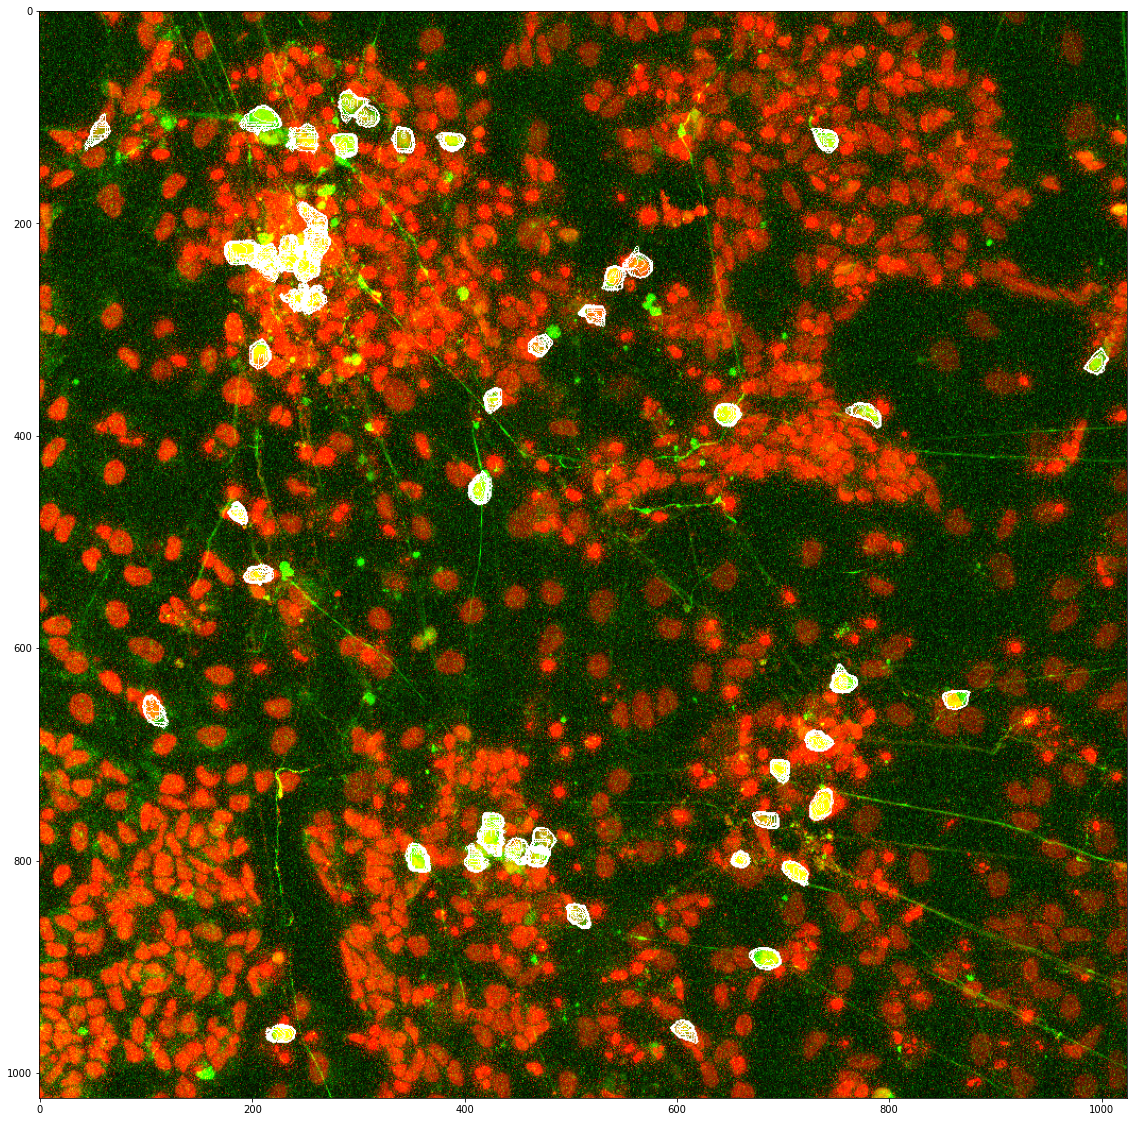

In [58]:
# show projection with filtering
plt.figure(figsize = (20,20))
mat2 = extract_channels([1,0], channels, mat)

show_maxproj_with_outlines(mat2, masks_copy)

100%|██████████| 20/20 [00:01<00:00, 16.27it/s]


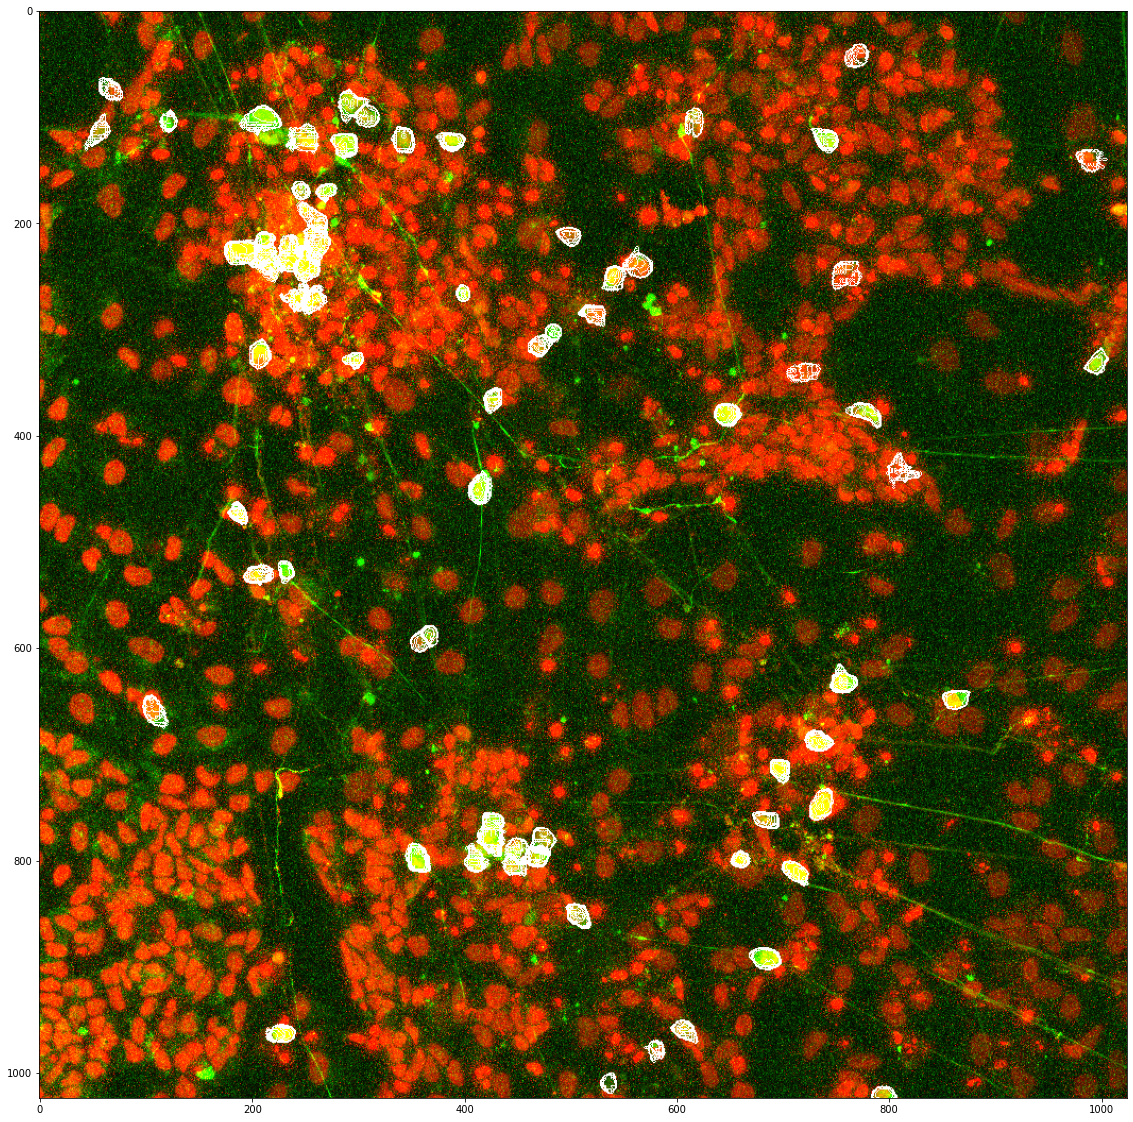

In [54]:
# show projection without filtering
plt.figure(figsize = (20,20))
mat2 = extract_channels([1,0], channels, mat)

show_maxproj_with_outlines(mat2, masks)

### Filter Y based on Params

In [92]:
# load image with channels from above
from aicsimageio import AICSImage
from confocalQuant.segmentation import load_3D

path = '../image_analysis2/D04_1.czi'
img = AICSImage(path)
out = load_3D(img, [0,1,2,3])


In [94]:
Y_filtered = get_im_stats(masks_copy, out, probs)

100%|██████████| 48/48 [01:30<00:00,  1.88s/it]
